In [19]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from model import MyUNet
from transform_manager import TransformManager
from utils import get_all_test_pairs_path

In [20]:
model_path = '../Models/crossval/0d5f16cf38/model_0d5f16cf38_s42_fold1.pth'

In [21]:
CAR_PICTURE_DIR = "../car_pictures/"

pictures = []

for root, dirs, files in os.walk(CAR_PICTURE_DIR):
    for file in files:
        if file.endswith(".png"):
            pictures.append(os.path.join(root, file))

print(len(pictures))

11133


In [22]:
image_path = random.choice(pictures)
print(f"Selected image: {image_path}")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_filters = [32, 64, 128, 256]
model = MyUNet(in_channels=3, out_channels=1, num_filters=num_filters, n_convs=2).to(device)
# print(f"Using device: {device}")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()


original_shape = image.shape
# print(f"Original image shape: {original_shape}")

transform_manager = TransformManager(num_encoders=len(num_filters), seed=42)
transform = transform_manager.get_eval_transform()
transformed = transform(image=image)
applied_transforms = transformed["applied_transforms"]
picture_tensor = transformed["image"]

# print(f"Transformed image shape: {picture_tensor.shape}")

if not all(x % len(num_filters) == 0 for x in picture_tensor.shape[1:]):
    print("Image dimensions are not divisible by the number of filters. Resizing...")

with torch.no_grad():
    picture_tensor = picture_tensor.unsqueeze(0).to(device)
    output = model(picture_tensor)
    output = torch.sigmoid(output)
    output = (output > 0.5).float()

Selected image: ../car_pictures/256_128/204_original_image.png


In [23]:
# print(f"Applied transforms: {applied_transforms}")

def get_resized_shape(applied_transforms: list):
    for name, params in applied_transforms:
        if name == "ResizeWithAspectRatio":
            return params.get("resized_shape", None)
    return None

Sample ray distances (first 10 rays):
0: 194
1: 187
2: 182
3: 177
4: 172
5: 169
6: 165
7: 162
8: 159
9: 158


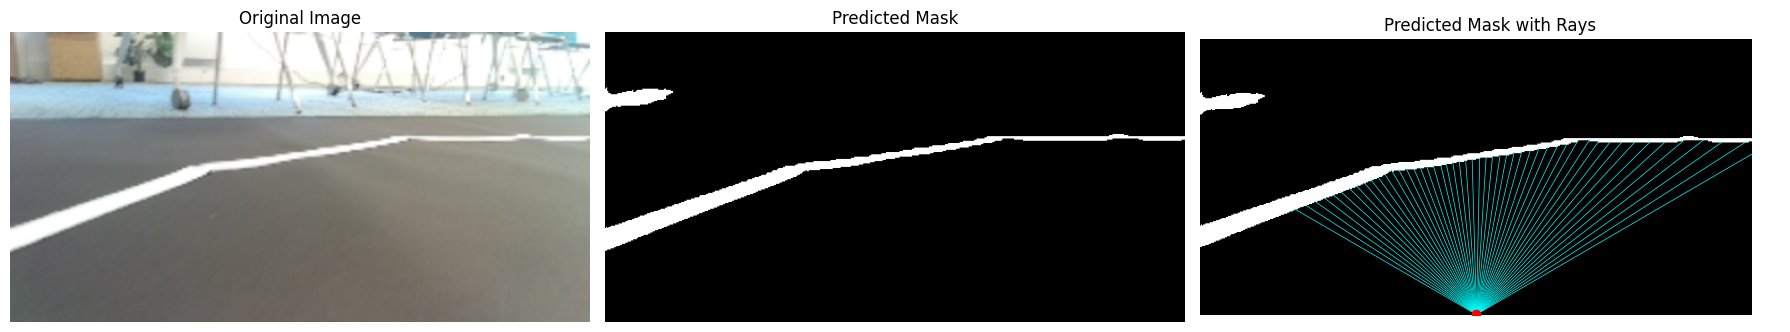

In [24]:
resized_shape = get_resized_shape(applied_transforms)
# print(f"Resized shape: {resized_shape}")

image = TransformManager.reverse_image(picture_tensor, resized_shape)
output_np = TransformManager.reverse_mask(output, resized_shape)

# print(f"Image shape after reverse: {image.shape}")
# print(f"Output mask shape after reverse: {output_np.shape}")

# Import the ray generator
from ray_generator import generate_rays, show_rays

distances, ray_endpoints = generate_rays(output_np, num_rays=50, fov_degrees=120)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predicted mask without rays
axes[1].imshow(output_np, cmap="gray")
axes[1].set_title("Predicted Mask")
axes[1].axis("off")

# Predicted mask with rays
axes[2].imshow(output_np, cmap="gray")
axes[2].set_title("Predicted Mask with Rays")
axes[2].axis("off")

height, width = output_np.shape
origin_x = width // 2
origin_y = height - 1

for end_x, end_y in ray_endpoints:
    axes[2].plot([origin_x, end_x], [origin_y, end_y], color='cyan', linewidth=0.5)

axes[2].plot(origin_x, origin_y, "ro")

print(f"Sample ray distances (first 10 rays):")
sample_rays = list(distances.items())[:10]
for ray, distance in sample_rays:
    print(f"{ray}: {distance}")

plt.tight_layout()
plt.show()